In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beckoliver","key":"848de19a3d6d1fc6166df8bd32d747f1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d obulisainaren/multi-cancer

100% 8.61G/8.62G [01:40<00:00, 98.5MB/s]
100% 8.62G/8.62G [01:40<00:00, 92.4MB/s]


In [ ]:
!unzip '/content/multi-cancer.zip'

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [51]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt

In [52]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [53]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

In [54]:
class ImageDataProcessor:
    def __init__(self, path):
        self.base_path = path
        self.train_datagen = ImageDataGenerator(validation_split=0.3)
        self.no_of_classes = 0
        self.class_names = []

    def initiate_generator(self):
        self._generate_dataset()
        self._generate_data_generators()
        self._plot_sample_images()
        self._print_image_shape()
        return (
            self.class_names,
            self.no_of_classes,
            self.train_generator,
            self.validation_generator,
        )

    def _generate_dataset(self):
        print("\nTotal : ", end=" ")
        self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            batch_size=32, directory=self.base_path
        )
        self.class_names = self.train_dataset.class_names
        self.no_of_classes = len(self.class_names)

    def _generate_data_generators(self):
        self.train_generator = self._create_generator(subset="training")
        self.validation_generator = self._create_generator(
            subset="validation", shuffle=False
        )
        print("\nNo of Classes : ", self.no_of_classes)
        print("Classes : ", self.class_names)

    def _create_generator(self, subset, shuffle=True):
        print(f"\nFor {subset.capitalize()} : ", end=" ")
        return self.train_datagen.flow_from_directory(
            self.base_path,
            target_size=(224, 224),
            batch_size=32,
            class_mode="categorical",
            subset=subset,
            shuffle=shuffle,
        )

    def _plot_sample_images(self):
        plt.figure(figsize=(10, 10))
        for images, labels in self.train_dataset.take(1):
            for i in range(self.no_of_classes):
                ax = plt.subplot(4, 4, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(self.class_names[labels[i]])
                plt.axis("off")

    def _print_image_shape(self):
        for image_batch, _ in self.train_dataset.take(1):
            print("Image Shape : ", image_batch.shape)
            break

In [15]:
class DataNormalizer:
    def __init__(self, train_generator, val_generator):
        self.train_generator = train_generator
        self.val_generator = val_generator
        self.normalized_ds = None
        self.AUTOTUNE = tf.data.AUTOTUNE

    def initiate_normalize(self):
        self._prepare_datasets()
        self._normalize_datasets()
        self._display_sample()

    def _prepare_datasets(self):
        self.train_ds = (
            self.train_generator.cache()
            .shuffle(1000)
            .prefetch(buffer_size=self.AUTOTUNE)
        )
        self.val_ds = self.val_generator.cache().prefetch(buffer_size=self.AUTOTUNE)

    def _normalize_datasets(self):
        normalization_layer = layers.Rescaling(1.0 / 255)
        self.normalized_ds = self.train_ds.map(lambda x, y: (normalization_layer(x), y))

    def _display_sample(self):
        image_batch, labels_batch = next(iter(self.normalized_ds))
        first_image = image_batch[0]
        print(
            f"Min pixel value: {np.min(first_image)}, Max pixel value: {np.max(first_image)}"
        )

In [55]:
class ImageClassifier:
    def __init__(
        self,
        no_of_classes,
        image_size,
        class_name,
        train_generator,
        validation_generator,
    ):
        self.no_of_classes = no_of_classes
        self.image_size = image_size
        self.class_name = class_name
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.model = None
        self.annealer = None
        self.checkpoint = None

    def initiate_model(self):
        model_input = tf.keras.applications.VGG16(
            input_shape=self.image_size + [3], include_top=False, weights="imagenet"
        )

        for layer in model_input.layers:
            layer.trainable = False

        x = Flatten()(model_input.output)
        prediction = Dense(self.no_of_classes, activation="softmax")(x)

        self.model = Model(inputs=model_input.input, outputs=prediction)
        return self.model

    def model_summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            print("Model has not been initialized yet.")

    def initiate_params(self, lr):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(
            optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
        )

        self.annealer = ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=5, verbose=1, min_lr=1e-3
        )
        self.checkpoint = ModelCheckpoint(
            self.class_name + "VGG16.h5", verbose=1, save_best_only=True
        )

        return self.model, self.annealer, self.checkpoint

    def model_fit(self, epochs=20, batch_size=256):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.annealer, self.checkpoint],
            steps_per_epoch=len(self.train_generator),
            validation_steps=len(self.validation_generator),
        )
        return history

    def eval_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        evl = self.model.evaluate(self.validation_generator)
        acc = evl[1] * 100
        msg = f"Accuracy on the Test Set = {acc:5.2f} %"
        print(msg)

    def save_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        file_path = self.class_name + " - VGG16.h5"
        self.model.save(file_path)
        print(f"Model saved to {file_path}!")

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


class PlotMetrics:

    def plot_output(self, history, epochs):
        acc = history.history["accuracy"]
        val_acc = history.history["val_accuracy"]
        loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        epochs_range = range(epochs)

        sns.set(style="whitegrid")
        plt.figure(figsize=(14, 5))

        plt.subplot(1, 2, 1)
        sns.lineplot(epochs_range, acc, label="Training Accuracy")
        sns.lineplot(epochs_range, val_acc, label="Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")
        plt.title("Training and Validation Accuracy")

        plt.subplot(1, 2, 2)
        sns.lineplot(epochs_range, loss, label="Training Loss")
        sns.lineplot(epochs_range, val_loss, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc="upper right")
        plt.title("Training and Validation Loss")

        plt.tight_layout()
        plt.show()
        plt.savefig(self.class_name + "_performance_graph.png")

    def plot_confusion_matrix(
        self, cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")

    def call_plot(self):
        y_true = self.validation_generator.classes
        y_pred = self.model.predict(self.validation_generator)
        y_pred = np.argmax(y_pred, axis=1)
        conf_mat = confusion_matrix(y_true, y_pred)

        self.plot_confusion_matrix(
            cm=conf_mat,
            normalize=False,
            target_names=self.class_names,
            title=self.class_name + " Confusion Matrix",
        )

In [ ]:
data_dir = "/content/Multi Cancer"
cancer_classes = os.listdir(data_dir)
print(cancer_classes)

#Cervical Caner



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
58889256/58889256 [==============================] - 0s 0us/step


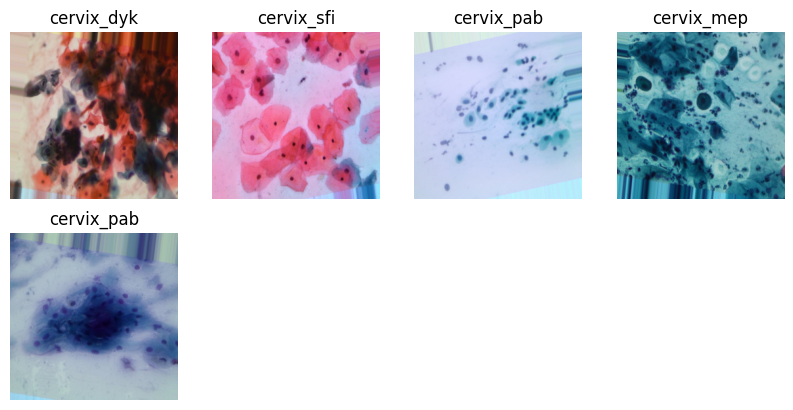

In [ ]:
target_class = "Cervical Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
cervical_model = classifierObj.initiate_model()

In [ ]:
cervical_model, cervical_annealer, cervical_model_checkpoints = (
    classifierObj.initiate_params(lr=0.001)
)

cervical_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 1.5969 - accuracy: 0.9218
Epoch 1: val_loss improved from inf to 0.42756, saving model to Cervical CancerVGG16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


547/547 [==============================] - 140s 239ms/step - loss: 1.5969 - accuracy: 0.9218 - val_loss: 0.4276 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.9821
Epoch 2: val_loss did not improve from 0.42756
547/547 [==============================] - 110s 201ms/step - loss: 0.3495 - accuracy: 0.9821 - val_loss: 0.6357 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.9869
Epoch 3: val_loss did not improve from 0.42756
547/547 [==============================] - 113s 207ms/step - loss: 0.3301 - accuracy: 0.9869 - val_loss: 0.6795 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9906
Epoch 4: val_loss did not improve from 0.42756
547/547 [==============================] - 101s 184ms/step - loss: 0.2382 - accuracy: 0.9906 - val_loss: 0.9004 - val_accuracy:

#Brain Cancer



Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 10500 images belonging to 3 classes.

For Validation :  Found 4500 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)


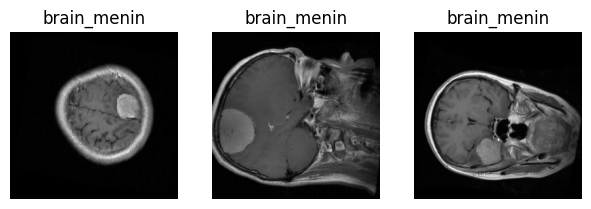

In [ ]:
target_class = "Brain Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
brain_model = classifierObj.initiate_model()

In [ ]:
brain_model, brain_annealer, brain_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

brain_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 2.5114 - accuracy: 0.8822
Epoch 1: val_loss improved from inf to 1.52511, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 67s 200ms/step - loss: 2.5114 - accuracy: 0.8822 - val_loss: 1.5251 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.9635
Epoch 2: val_loss improved from 1.52511 to 0.99328, saving model to Brain CancerVGG16.h5
329/329 [==============================] - 59s 178ms/step - loss: 0.6724 - accuracy: 0.9635 - val_loss: 0.9933 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.9715
Epoch 3: val_loss did not improve from 0.99328
329/329 [==============================] - 59s 180ms/step - loss: 0.5950 - accuracy: 0.9715 - val_loss: 1.0399 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 4/10
329/329 [==============================

#Kidney Cancer



Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)


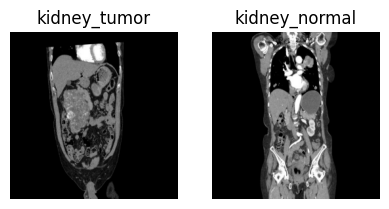

In [ ]:
target_class = "Kidney Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
kidney_model = classifierObj.initiate_model()

In [ ]:
kidney_model, kidney_annealer, kidney_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

kidney_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.9178 - accuracy: 0.9723
Epoch 1: val_loss improved from inf to 4.81805, saving model to Kidney CancerVGG16.h5
219/219 [==============================] - 46s 204ms/step - loss: 0.9178 - accuracy: 0.9723 - val_loss: 4.8181 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9984
Epoch 2: val_loss did not improve from 4.81805
219/219 [==============================] - 47s 214ms/step - loss: 0.0171 - accuracy: 0.9984 - val_loss: 8.0578 - val_accuracy: 0.8107 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 6.9991e-09 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 4.81805
219/219 [==============================] - 38s 171ms/step - loss: 6.9991e-09 - accuracy: 1.0000 - val_loss: 8.3781 - val_accuracy: 0.8103 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - ETA: 0s - loss: 6.8288e-09 - 

#Breast Cancer



Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)


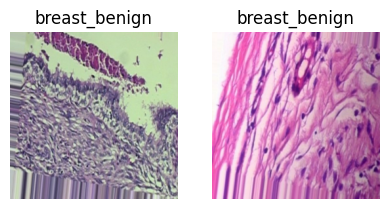

In [ ]:
target_class = "Breast Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
breast_model = classifierObj.initiate_model()

In [ ]:
breast_model, breast_annealer, breast_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

breast_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.9664
Epoch 1: val_loss improved from inf to 0.93040, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 83s 374ms/step - loss: 0.7867 - accuracy: 0.9664 - val_loss: 0.9304 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9897
Epoch 2: val_loss improved from 0.93040 to 0.61858, saving model to Breast CancerVGG16.h5
219/219 [==============================] - 67s 307ms/step - loss: 0.2232 - accuracy: 0.9897 - val_loss: 0.6186 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9943
Epoch 3: val_loss did not improve from 0.61858
219/219 [==============================] - 66s 302ms/step - loss: 0.1185 - accuracy: 0.9943 - val_loss: 0.9227 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 4/10
219/219 [============================

#Lung and Colon Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 17500 images belonging to 5 classes.

For Validation :  Found 7500 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)


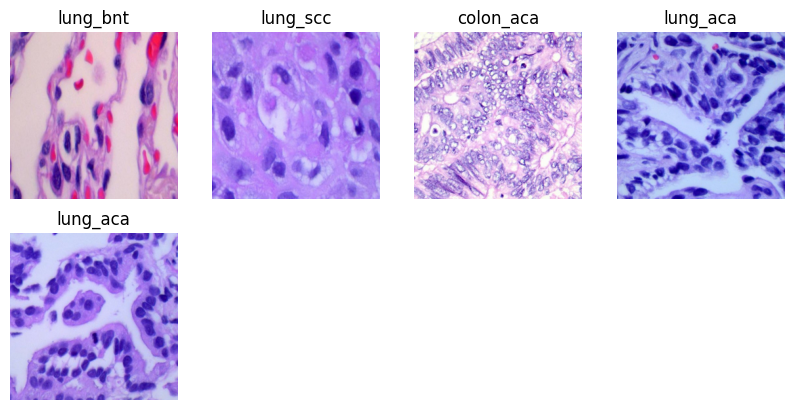

In [ ]:
target_class = "Lung and Colon Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lung_model = classifierObj.initiate_model()

In [ ]:
lung_model, lung_annealer, lung_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

lung_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
547/547 [==============================] - ETA: 0s - loss: 1.4423 - accuracy: 0.9375
Epoch 1: val_loss improved from inf to 0.65323, saving model to Lung and Colon CancerVGG16.h5
547/547 [==============================] - 107s 194ms/step - loss: 1.4423 - accuracy: 0.9375 - val_loss: 0.6532 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.9799
Epoch 2: val_loss did not improve from 0.65323
547/547 [==============================] - 97s 177ms/step - loss: 0.5033 - accuracy: 0.9799 - val_loss: 0.7262 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9907
Epoch 3: val_loss did not improve from 0.65323
547/547 [==============================] - 109s 200ms/step - loss: 0.2257 - accuracy: 0.9907 - val_loss: 0.7402 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - ETA: 0s - loss: 0.3060 - ac

#Lymphoma


In [ ]:
target_class = "Lymphoma"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lymph_model = classifierObj.initiate_model()

In [ ]:
lymph_model, lymph_annealer, lymph_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

lymph_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
329/329 [==============================] - ETA: 0s - loss: 5.4588 - accuracy: 0.6607
Epoch 1: val_loss improved from inf to 3.79739, saving model to LymphomaVGG16.h5
329/329 [==============================] - 78s 233ms/step - loss: 5.4588 - accuracy: 0.6607 - val_loss: 3.7974 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 2/10
329/329 [==============================] - ETA: 0s - loss: 2.0324 - accuracy: 0.8368
Epoch 2: val_loss improved from 3.79739 to 2.85107, saving model to LymphomaVGG16.h5
329/329 [==============================] - 66s 201ms/step - loss: 2.0324 - accuracy: 0.8368 - val_loss: 2.8511 - val_accuracy: 0.8080 - lr: 0.0010
Epoch 3/10
329/329 [==============================] - ETA: 0s - loss: 1.4824 - accuracy: 0.8795
Epoch 3: val_loss improved from 2.85107 to 2.78445, saving model to LymphomaVGG16.h5
329/329 [==============================] - 65s 198ms/step - loss: 1.4824 - accuracy: 0.8795 - val_loss: 2.7845 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 4/10
329/329 [

#Oral Cancer



Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 7002 images belonging to 2 classes.

For Validation :  Found 3000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)


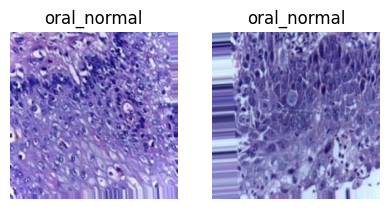

In [ ]:
target_class = "Oral Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObj = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
oral_model = classifierObj.initiate_model()

In [ ]:
oral_model, oral_annealer, oral_model_checkpoints = classifierObj.initiate_params(
    lr=0.001
)

oral_model_history = classifierObj.model_fit(epochs=10, batch_size=256)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 6.6487 - accuracy: 0.7398
Epoch 1: val_loss improved from inf to 4.59375, saving model to Oral CancerVGG16.h5
219/219 [==============================] - 50s 223ms/step - loss: 6.6487 - accuracy: 0.7398 - val_loss: 4.5937 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 2.4857 - accuracy: 0.8892
Epoch 2: val_loss did not improve from 4.59375
219/219 [==============================] - 49s 222ms/step - loss: 2.4857 - accuracy: 0.8892 - val_loss: 5.0931 - val_accuracy: 0.8260 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 1.4420 - accuracy: 0.9254
Epoch 3: val_loss did not improve from 4.59375
219/219 [==============================] - 40s 180ms/step - loss: 1.4420 - accuracy: 0.9254 - val_loss: 5.2399 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 4/10
219/219 [==============================] - ETA: 0s - loss: 1.2701 - accuracy: 0.93

#EfficientNet Model


In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf


class EfficientNetClassifier:
    def __init__(
        self,
        no_of_classes,
        image_size,
        class_name,
        train_generator,
        validation_generator,
    ):
        self.no_of_classes = no_of_classes
        self.image_size = image_size
        self.class_name = class_name
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.model = None
        self.annealer = None
        self.checkpoint = None

    def initiate_model(self):
        model_input = EfficientNetB0(
            input_shape=self.image_size + [3], include_top=False, weights="imagenet"
        )

        for layer in model_input.layers:
            layer.trainable = False

        x = Flatten()(model_input.output)
        prediction = Dense(self.no_of_classes, activation="relu")(x)

        # Create the model object
        self.model = Model(inputs=model_input.input, outputs=prediction)
        return self.model

    def model_summary(self):
        if self.model is not None:
            self.model.summary()
        else:
            print("Model has not been initialized yet.")

    def initiate_params(self, lr):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.model.compile(
            optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"]
        )

        self.annealer = ReduceLROnPlateau(
            monitor="val_accuracy", factor=0.5, patience=5, verbose=1, min_lr=1e-3
        )
        self.checkpoint = ModelCheckpoint(
            self.class_name + "EfficientNetB0.h5", verbose=1, save_best_only=True
        )

        return self.model, self.annealer, self.checkpoint

    def model_fit(self, epochs=20, batch_size=256):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        history = self.model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[self.annealer, self.checkpoint],
            steps_per_epoch=len(self.train_generator),
            validation_steps=len(self.validation_generator),
        )
        return history

    def eval_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        # Evaluate the model
        evl = self.model.evaluate(self.validation_generator)
        acc = evl[1] * 100
        msg = f"Accuracy on the Test Set = {acc:5.2f} %"
        print(msg)

    def save_model(self):
        if self.model is None:
            print("Model has not been initialized yet.")
            return

        file_path = self.class_name + " - EfficientNetB0.h5"
        self.model.save(file_path)
        print(f"Model saved to {file_path}!")

# Cervical Cancer


In [ ]:
target_class = "Cervical Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
cervical_modelB0 = classifierObjB0.initiate_model()

In [ ]:
cervical_modelB0, cervical_annealerB0, cervical_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

cervical_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 1003 files belonging to 5 classes.

For Training :  Found 704 images belonging to 5 classes.

For Validation :  Found 299 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)


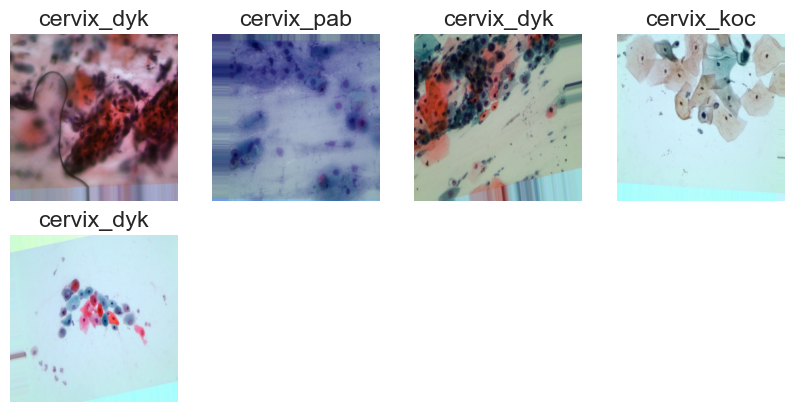

In [77]:
target_class = "Cervical Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

cervical_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
cervical_model.model = tf.keras.models.load_model("models\\cervical_model1.h5")


In [78]:
model = cervical_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

10/10 [==============================] - 118s 11s/step


In [27]:
import seaborn as sns

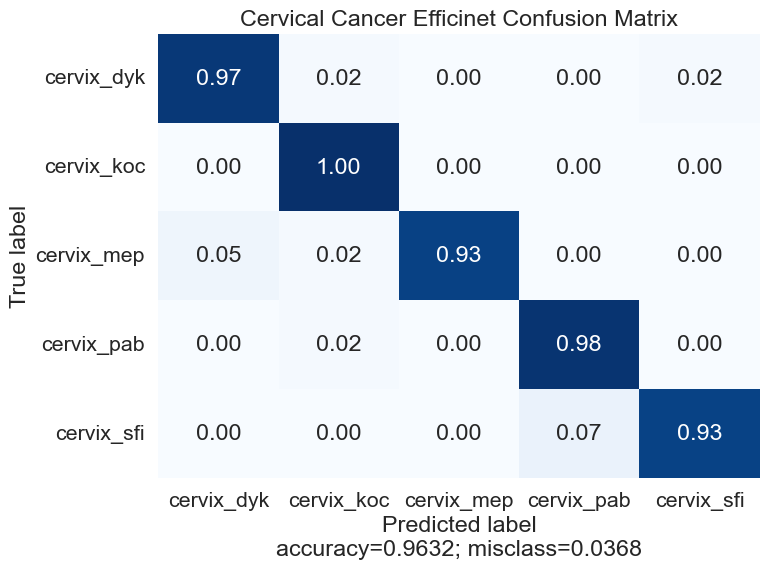

<Figure size 640x480 with 0 Axes>

In [79]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Cervical Cancer Efficinet Confusion Matrix")

In [80]:
from sklearn.metrics import classification_report
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

10/10 [==============================] - 99s 10s/step
              precision    recall  f1-score   support

  cervix_dyk       0.95      0.97      0.96        59
  cervix_koc       0.95      1.00      0.98        59
  cervix_mep       1.00      0.93      0.97        61
  cervix_pab       0.94      0.98      0.96        60
  cervix_sfi       0.98      0.93      0.96        60

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299



#Brain Cancer


In [ ]:
target_class = "Brain Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
brain_modelB0 = classifierObjB0.initiate_model()

In [ ]:
brain_modelB0, brain_annealerB0, brain_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

brain_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 600 files belonging to 3 classes.

For Training :  Found 420 images belonging to 3 classes.

For Validation :  Found 180 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)


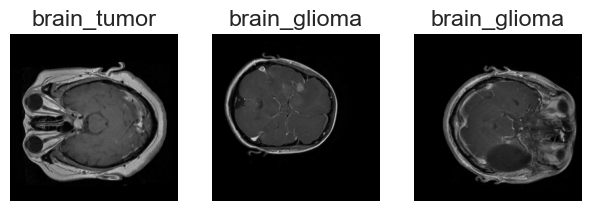

In [57]:
target_class = "Brain Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

brain_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
brain_model.model = tf.keras.models.load_model("models\\brain_model1.h5")


In [58]:
model = brain_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

6/6 [==============================] - 69s 12s/step


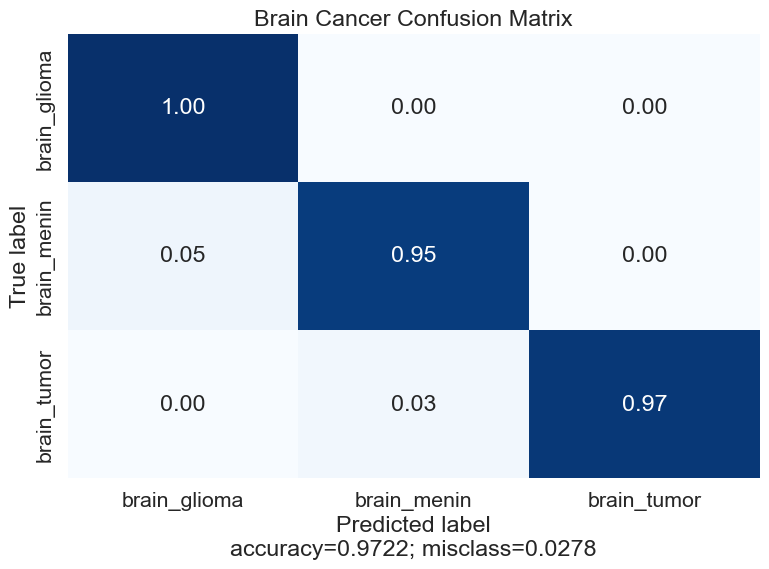

<Figure size 640x480 with 0 Axes>

In [59]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Brain Cancer Confusion Matrix")

In [60]:
from sklearn.metrics import classification_report
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

6/6 [==============================] - 73s 13s/step
              precision    recall  f1-score   support

brain_glioma       0.95      1.00      0.98        60
 brain_menin       0.97      0.95      0.96        60
 brain_tumor       1.00      0.97      0.98        60

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



#Kidney Cancer


In [ ]:
target_class = "Kidney Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
kidney_modelB0 = classifierObjB0.initiate_model()

In [ ]:
kidney_modelB0, kidney_annealerB0, kidney_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

kidney_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 400 files belonging to 2 classes.

For Training :  Found 280 images belonging to 2 classes.

For Validation :  Found 120 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)


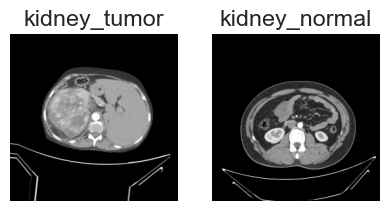

In [101]:
target_class = "Kidney Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

kidney_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
kidney_model.model = tf.keras.models.load_model("models\\kidney_model1.h5")

In [102]:
model = kidney_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

4/4 [==============================] - 44s 11s/step


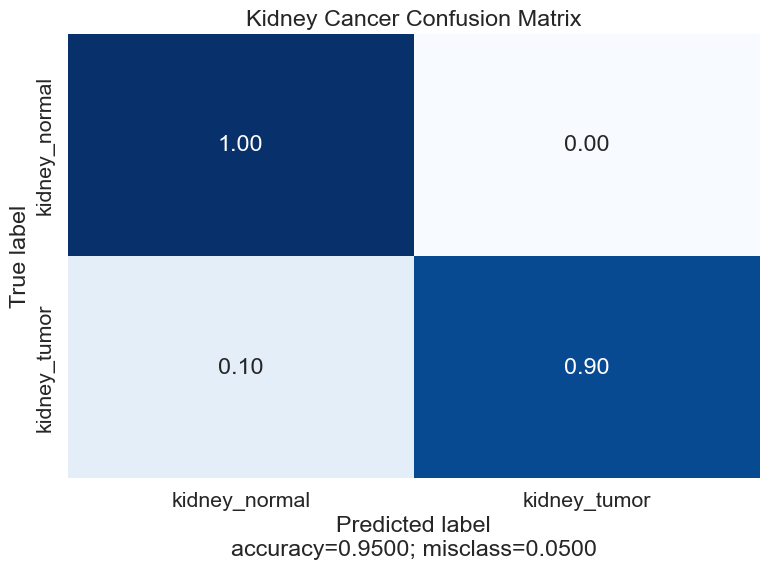

<Figure size 640x480 with 0 Axes>

In [103]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Kidney Cancer Confusion Matrix")

In [104]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

4/4 [==============================] - 47s 12s/step
               precision    recall  f1-score   support

kidney_normal       0.91      1.00      0.95        60
 kidney_tumor       1.00      0.90      0.95        60

     accuracy                           0.95       120
    macro avg       0.95      0.95      0.95       120
 weighted avg       0.95      0.95      0.95       120



#Breast Cancer


In [ ]:
target_class = "Breast Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
breast_modelB0 = classifierObjB0.initiate_model()

In [ ]:
breast_modelB0, breast_annealerB0, breast_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

breast_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 400 files belonging to 2 classes.

For Training :  Found 280 images belonging to 2 classes.

For Validation :  Found 120 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)


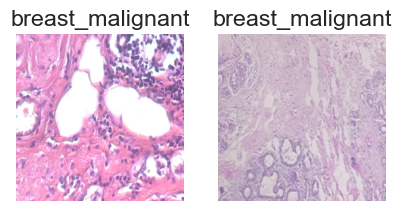

In [61]:
target_class = "Breast Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

breast_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
breast_model.model = tf.keras.models.load_model("models\\breast_model1.h5")


In [62]:
model = breast_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

4/4 [==============================] - 40s 10s/step


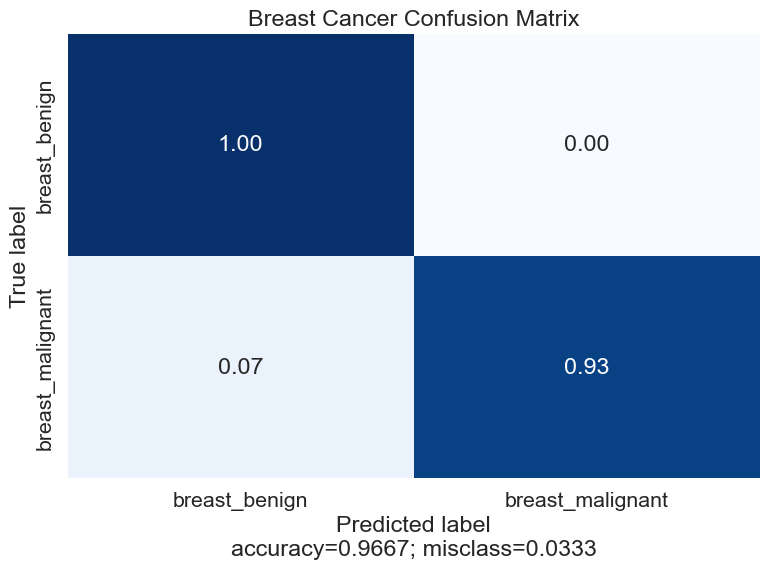

<Figure size 640x480 with 0 Axes>

In [63]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Breast Cancer Confusion Matrix")

In [64]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

4/4 [==============================] - 42s 10s/step
                  precision    recall  f1-score   support

   breast_benign       0.94      1.00      0.97        60
breast_malignant       1.00      0.93      0.97        60

        accuracy                           0.97       120
       macro avg       0.97      0.97      0.97       120
    weighted avg       0.97      0.97      0.97       120



#Lung and Colon Cancer


In [ ]:
target_class = "Lung and Colon Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lung_modelB0 = classifierObjB0.initiate_model()

In [ ]:
lung_modelB0, lung_annealerB0, lung_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

lung_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 1000 files belonging to 5 classes.

For Training :  Found 701 images belonging to 5 classes.

For Validation :  Found 299 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)


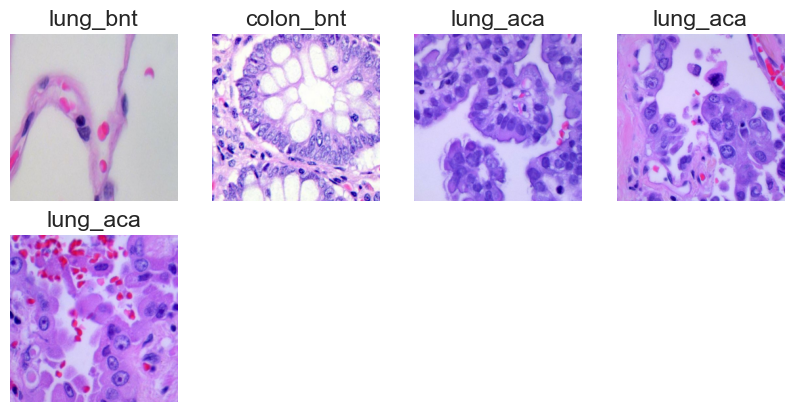

In [88]:
target_class = "Lung and Colon Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

lung_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lung_model.model = tf.keras.models.load_model("models\\lung_model1.h5")


In [89]:
model = lung_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

10/10 [==============================] - 128s 13s/step


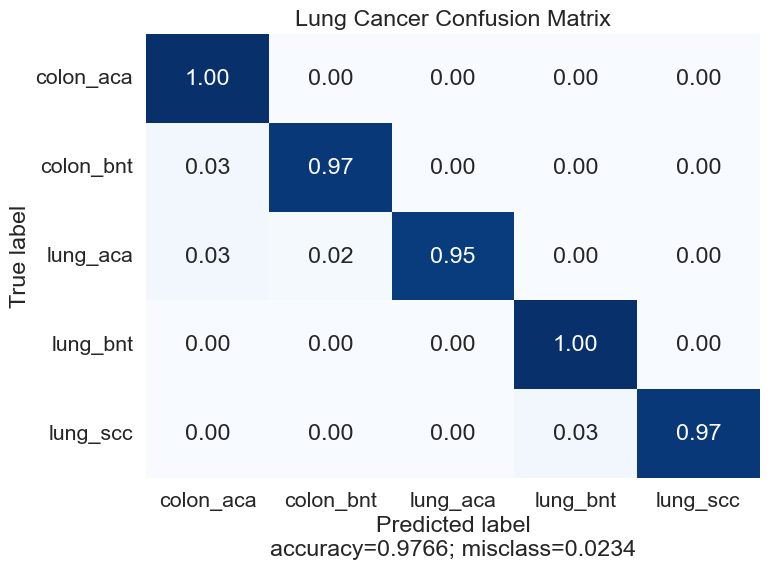

<Figure size 640x480 with 0 Axes>

In [90]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Lung Cancer Confusion Matrix")

In [91]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

10/10 [==============================] - 110s 11s/step
              precision    recall  f1-score   support

   colon_aca       0.94      1.00      0.97        60
   colon_bnt       0.98      0.97      0.97        60
    lung_aca       1.00      0.95      0.97        60
    lung_bnt       0.97      1.00      0.98        60
    lung_scc       1.00      0.97      0.98        59

    accuracy                           0.98       299
   macro avg       0.98      0.98      0.98       299
weighted avg       0.98      0.98      0.98       299



#Lymphoma


In [ ]:
target_class = "Lymphoma Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lymph_modelB0 = classifierObjB0.initiate_model()

In [ ]:
lymph_modelB0, lymph_annealerB0, lymph_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

lymph_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 600 files belonging to 3 classes.

For Training :  Found 420 images belonging to 3 classes.

For Validation :  Found 180 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)


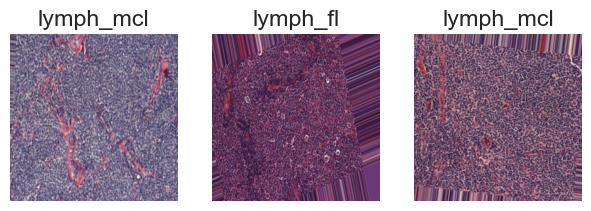

In [93]:
target_class = "Lymphoma"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

lymph_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lymph_model.model = tf.keras.models.load_model("models\\lymph_model1.h5")


In [94]:
model = lymph_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

6/6 [==============================] - 78s 13s/step


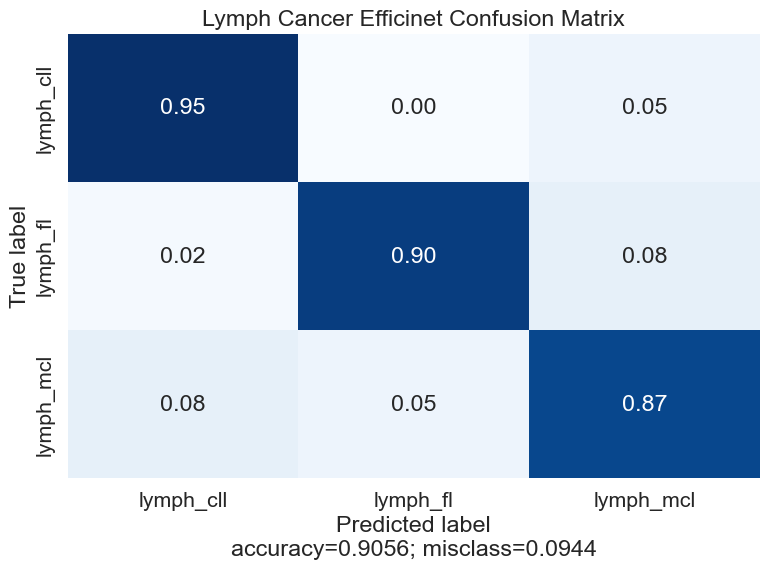

<Figure size 640x480 with 0 Axes>

In [96]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Lymph Cancer Efficinet Confusion Matrix")

In [95]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

6/6 [==============================] - 78s 13s/step
              precision    recall  f1-score   support

   lymph_cll       0.90      0.95      0.93        60
    lymph_fl       0.95      0.90      0.92        60
   lymph_mcl       0.87      0.87      0.87        60

    accuracy                           0.91       180
   macro avg       0.91      0.91      0.91       180
weighted avg       0.91      0.91      0.91       180



#Oral Cancer


In [ ]:
target_class = "Cervical Cancer"
target_data_path = f"/content/Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

classifierObjB0 = EfficientNetClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
oral_modelB0 = classifierObjB0.initiate_model()

In [ ]:
oral_modelB0, oral_annealerB0, oral_model_checkpointsB0 = (
    classifierObjB0.initiate_params(lr=1)
)

oral_model_history_B0 = classifierObjB0.model_fit(epochs=10, batch_size=256)


Total :  Found 400 files belonging to 2 classes.

For Training :  Found 280 images belonging to 2 classes.

For Validation :  Found 120 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)


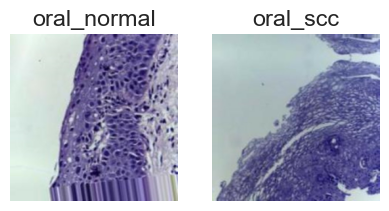

In [97]:
target_class = "Oral Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

oral_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
oral_model.model = tf.keras.models.load_model("models\\oral_model1.h5")

In [98]:
model = oral_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

4/4 [==============================] - 58s 13s/step


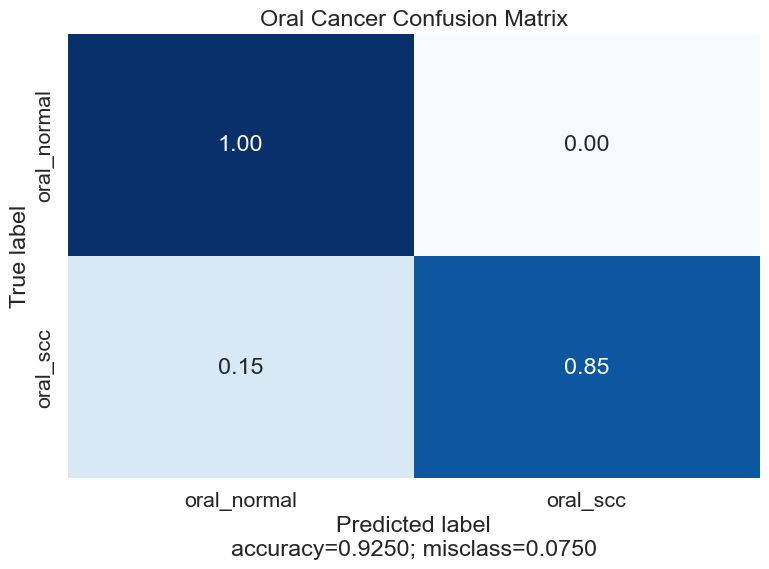

<Figure size 640x480 with 0 Axes>

In [99]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Oral Cancer Confusion Matrix")

In [100]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

4/4 [==============================] - 49s 11s/step
              precision    recall  f1-score   support

 oral_normal       0.87      1.00      0.93        60
    oral_scc       1.00      0.85      0.92        60

    accuracy                           0.93       120
   macro avg       0.93      0.93      0.92       120
weighted avg       0.93      0.93      0.92       120



# Evaluation


### Cervical Cancer



Total :  Found 500 files belonging to 5 classes.



For Training :  Found 350 images belonging to 5 classes.

For Validation :  Found 150 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
      

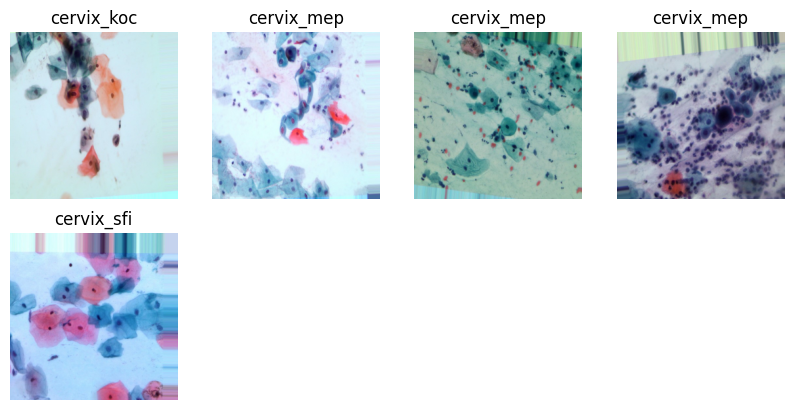

In [22]:
target_class = "Cervical Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

cervical_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
cervical_model.model = tf.keras.models.load_model("models\\cervical_model.h5")
cervical_model.model.summary()

In [12]:
cervical_model.eval_model()


5/5 [==============================] - 14s 3s/step - loss: 0.7180 - accuracy: 0.9933
Accuracy on the Test Set = 99.33 %


In [13]:
model = cervical_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))


5/5 [==============================] - 19s 4s/step


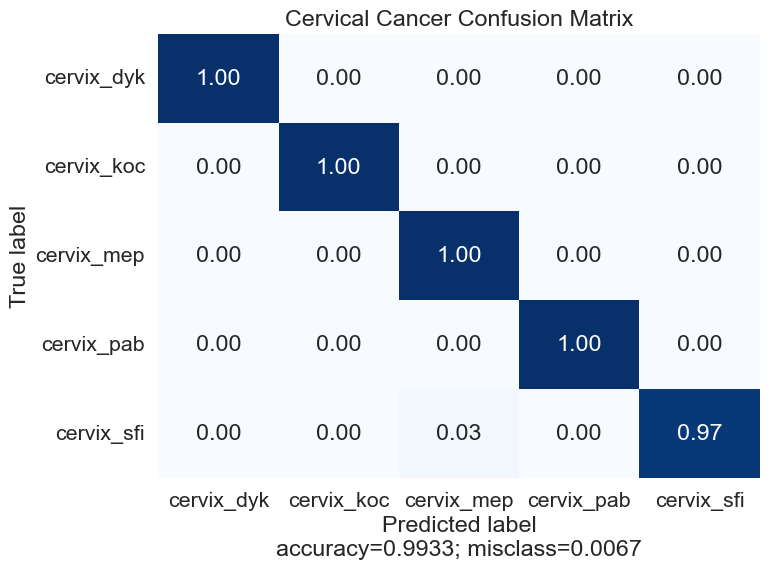

<Figure size 640x480 with 0 Axes>

In [14]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Cervical Cancer Confusion Matrix")

In [15]:
# classification_report
from sklearn.metrics import classification_report
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

5/5 [==============================] - 18s 4s/step
              precision    recall  f1-score   support

  cervix_dyk       1.00      1.00      1.00        30
  cervix_koc       1.00      1.00      1.00        30
  cervix_mep       0.97      1.00      0.98        30
  cervix_pab       1.00      1.00      1.00        30
  cervix_sfi       1.00      0.97      0.98        30

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



Brain Cancer


Total :  Found 300 files belonging to 3 classes.



For Training :  Found 210 images belonging to 3 classes.

For Validation :  Found 90 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                             

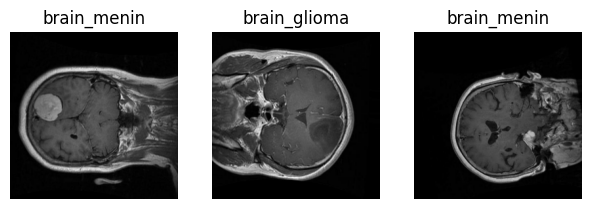

In [25]:
target_class = "Brain Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

cervical_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
cervical_model.model = tf.keras.models.load_model("models\\brain_model.h5")
cervical_model.model.summary()

In [26]:
cervical_model.eval_model()


3/3 [==============================] - 30s 8s/step - loss: 0.9823 - accuracy: 0.9667
Accuracy on the Test Set = 96.67 %


In [27]:
model = cervical_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

3/3 [==============================] - 24s 8s/step


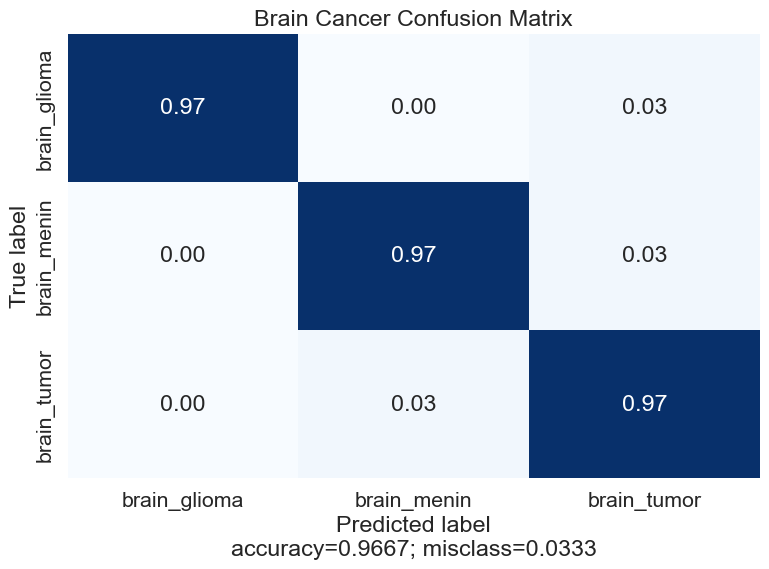

<Figure size 640x480 with 0 Axes>

In [28]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Brain Cancer Confusion Matrix")

In [29]:
from sklearn.metrics import classification_report
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

3/3 [==============================] - 26s 9s/step
              precision    recall  f1-score   support

brain_glioma       1.00      0.97      0.98        30
 brain_menin       0.97      0.97      0.97        30
 brain_tumor       0.94      0.97      0.95        30

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90



Breast Cancer


Total :  Found 200 files belonging to 2 classes.

For Training :  Found 140 images belonging to 2 classes.

For Validation :  Found 60 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     7

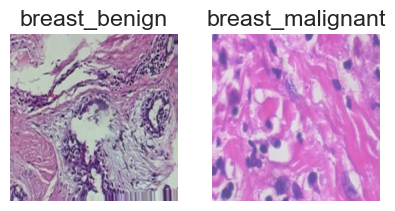

In [30]:
target_class = "Breast Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

breast_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
breast_model.model = tf.keras.models.load_model("models\\breast_model.h5")
breast_model.model.summary()

In [31]:
breast_model.eval_model()

2/2 [==============================] - 20s 8s/step - loss: 0.3349 - accuracy: 0.9833
Accuracy on the Test Set = 98.33 %


In [32]:
model = breast_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

2/2 [==============================] - 21s 9s/step


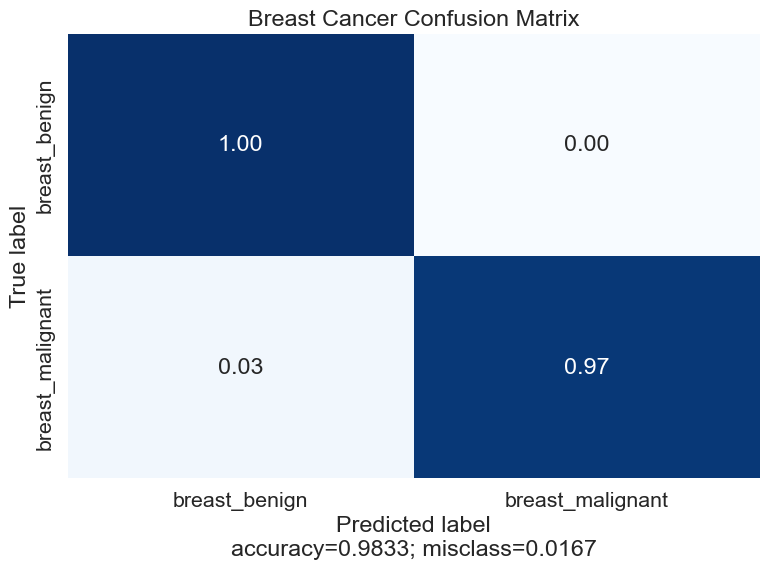

<Figure size 640x480 with 0 Axes>

In [33]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Breast Cancer Confusion Matrix")

In [34]:

print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

2/2 [==============================] - 20s 10s/step
                  precision    recall  f1-score   support

   breast_benign       0.97      1.00      0.98        30
breast_malignant       1.00      0.97      0.98        30

        accuracy                           0.98        60
       macro avg       0.98      0.98      0.98        60
    weighted avg       0.98      0.98      0.98        60



Kidney Cancer


Total :  Found 200 files belonging to 2 classes.

For Training :  Found 140 images belonging to 2 classes.

For Validation :  Found 60 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     738

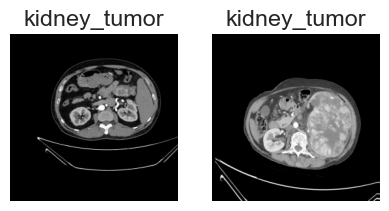

In [35]:
target_class = "Kidney Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

kidney_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
kidney_model.model = tf.keras.models.load_model("models\\kidney_model.h5")
kidney_model.model.summary()

In [36]:
kidney_model.eval_model()

2/2 [==============================] - 21s 9s/step - loss: 0.0000e+00 - accuracy: 1.0000
Accuracy on the Test Set = 100.00 %


In [37]:
model = kidney_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

2/2 [==============================] - 19s 9s/step


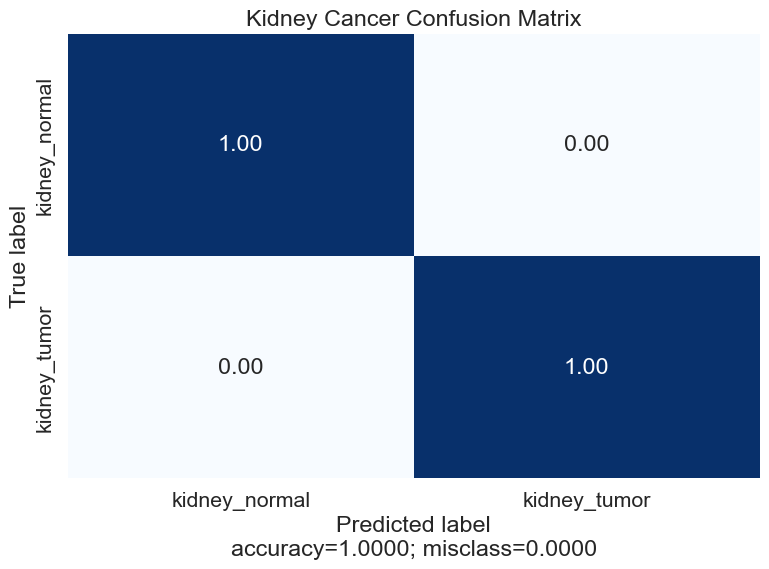

<Figure size 640x480 with 0 Axes>

In [38]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Kidney Cancer Confusion Matrix")

In [39]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

2/2 [==============================] - 24s 11s/step
               precision    recall  f1-score   support

kidney_normal       1.00      1.00      1.00        30
 kidney_tumor       1.00      1.00      1.00        30

     accuracy                           1.00        60
    macro avg       1.00      1.00      1.00        60
 weighted avg       1.00      1.00      1.00        60



Lung Cancer


Total :  Found 500 files belonging to 5 classes.

For Training :  Found 350 images belonging to 5 classes.

For Validation :  Found 150 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (

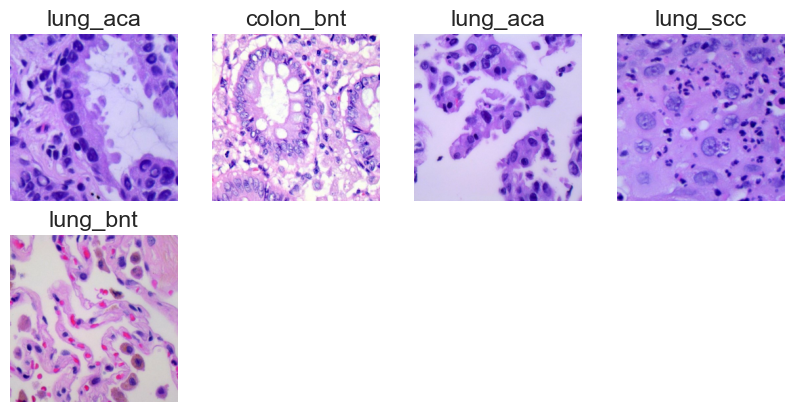

In [41]:
target_class = "Lung and Colon Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

lung_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lung_model.model = tf.keras.models.load_model("models\\lung_model.h5")
lung_model.model.summary()

In [42]:
lung_model.eval_model()

5/5 [==============================] - 49s 10s/step - loss: 4.6698e-06 - accuracy: 1.0000
Accuracy on the Test Set = 100.00 %


In [43]:
model = lung_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

5/5 [==============================] - 56s 11s/step


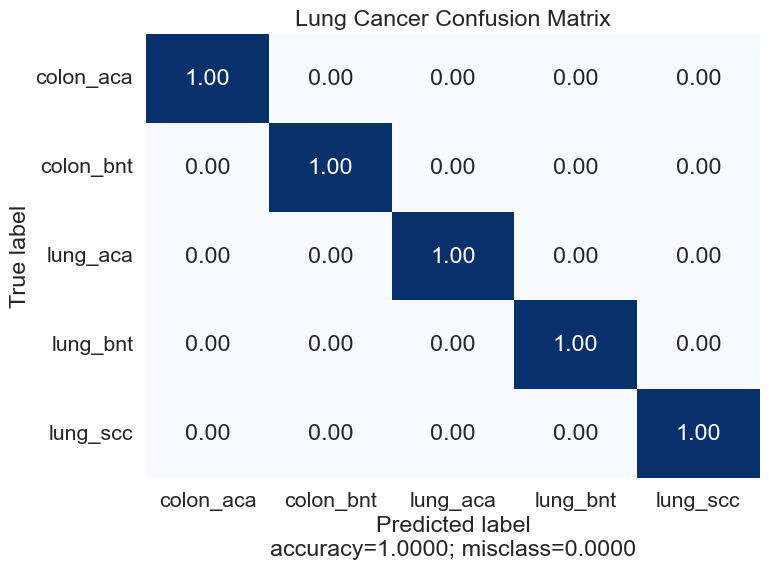

<Figure size 640x480 with 0 Axes>

In [44]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Lung Cancer Confusion Matrix")

In [45]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

5/5 [==============================] - 50s 10s/step
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00        30
   colon_bnt       1.00      1.00      1.00        30
    lung_aca       1.00      1.00      1.00        30
    lung_bnt       1.00      1.00      1.00        30
    lung_scc       1.00      1.00      1.00        30

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



Lymphoma Cancer


Total :  Found 300 files belonging to 3 classes.

For Training :  Found 210 images belonging to 3 classes.

For Validation :  Found 90 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     

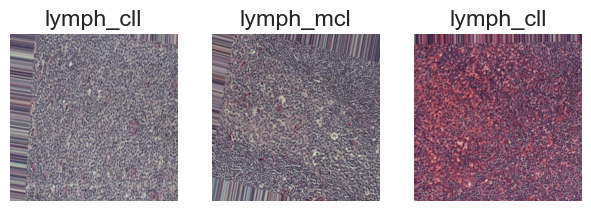

In [47]:
target_class = "Lymphoma"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

lymph_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
lymph_model.model = tf.keras.models.load_model("models\\lymph_model.h5")
lymph_model.model.summary()

In [48]:
lymph_model.eval_model()

3/3 [==============================] - 35s 11s/step - loss: 4.0837 - accuracy: 0.7667
Accuracy on the Test Set = 76.67 %


In [49]:
model = lymph_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

3/3 [==============================] - 38s 13s/step


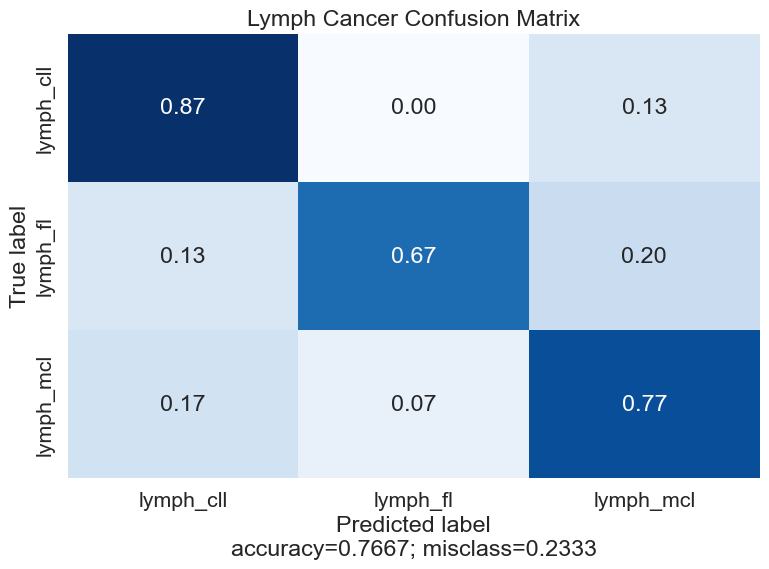

<Figure size 640x480 with 0 Axes>

In [50]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Lymph Cancer Confusion Matrix")

In [51]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

3/3 [==============================] - 43s 13s/step
              precision    recall  f1-score   support

   lymph_cll       0.74      0.87      0.80        30
    lymph_fl       0.91      0.67      0.77        30
   lymph_mcl       0.70      0.77      0.73        30

    accuracy                           0.77        90
   macro avg       0.78      0.77      0.77        90
weighted avg       0.78      0.77      0.77        90



Oral Cancer


Total :  Found 200 files belonging to 2 classes.

For Training :  Found 140 images belonging to 2 classes.

For Validation :  Found 60 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856    

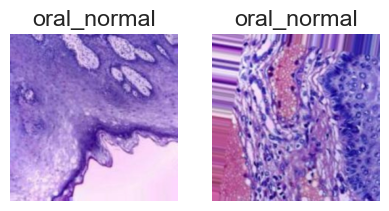

In [52]:
target_class = "Oral Cancer"
target_data_path = f"Multi Cancer/{target_class}"

dataProcessor = ImageDataProcessor(target_data_path)
classes, class_count, train_gen, valid_gen = dataProcessor.initiate_generator()

oral_model = ImageClassifier(
    no_of_classes=class_count,
    class_name=target_class,
    image_size=[224, 224],
    train_generator=train_gen,
    validation_generator=valid_gen,
)
oral_model.model = tf.keras.models.load_model("models\\oral_model.h5")
oral_model.model.summary()

In [53]:
oral_model.eval_model()

2/2 [==============================] - 24s 10s/step - loss: 6.3217 - accuracy: 0.8000
Accuracy on the Test Set = 80.00 %


In [54]:
model = oral_model.model
model.predict(valid_gen)

cm = confusion_matrix(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1))

2/2 [==============================] - 20s 9s/step


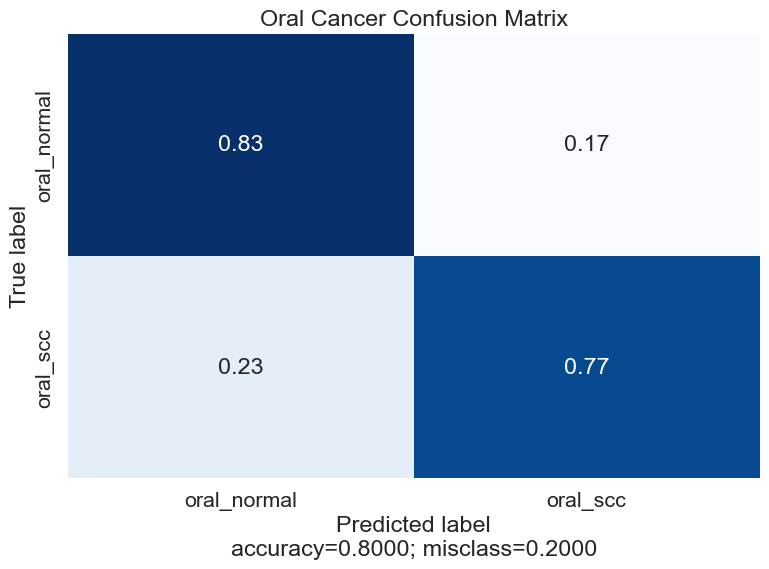

<Figure size 640x480 with 0 Axes>

In [55]:
def plot_confusion_matrix(cm, target_names, title="Confusion matrix", normalize=True
    ):
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1.4)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            cbar=False,
            xticklabels=target_names,
            yticklabels=target_names,
        )
        plt.title(title)
        plt.ylabel("True label")
        plt.xlabel(
            f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}"
        )
        plt.tight_layout()
        plt.show()
        plt.savefig(title + ".png")
        
plot_confusion_matrix(cm=cm, target_names=classes, title="Oral Cancer Confusion Matrix")

In [56]:
print(classification_report(valid_gen.classes, np.argmax(model.predict(valid_gen), axis=-1), target_names=classes))

2/2 [==============================] - 20s 9s/step
              precision    recall  f1-score   support

 oral_normal       0.78      0.83      0.81        30
    oral_scc       0.82      0.77      0.79        30

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

